# Parte 4: Clasificación con CNN

### Resultados con la arquitectura anterior: 

Primero

### Cambios realizados

### Nuevos resultados: 

Resultados:
    
    TRAIN                   DEV
    loss       accuracy     val_loss    val_accuracy
    0.106621	0.990385	1.769947	0.423077
    
Por tanto: 

    E = 1 - Accuracy
    Etrain = 1 - 0.990385 = 0.009615
    Etest = 1 - 0.423077 = 0.576923
    
    Bias = Etrain - Ehuman = 0.009615
    Variance = Etest - Etrain = 0.576923 - 0.009615 = 0.567308

El bias se encuentra bajo (1%), pero la varianza es alta (57%), hay que tratar de reducirla.  Para ello habrá que o regularizar, o cambiar la arquitectura (menos neuronas => Mejor varianza, más capas => mayor abstracción), o añadir más datos (cosa que no es posible). SE OBSERVA UN GRAN OVERFITTING!!!!!!!!!!!!


### 1 - Import Libraries

In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Signal libraries
from scipy import signal


### 2 - Load data

In [2]:
class ROutput:
    def __init__(self, task, data):
        self.task = task
        self.data = data
        
class OutTaskData: 
    def __init__(self, task, data): 
        self.task = task
        self.data = data

In [3]:
import scipy.io as sio
# Primero leemos los registros
def read_outputs(rec):
    '''read_outputs("userS0091f1.mat")'''
    mat = sio.loadmat(rec)
    mdata = mat['session']
    val = mdata[0,0]
    #output = ROutput(np.array(val["task"]), np.array(val["data"]))
    output = ROutput(np.array(val["task_EEG_p"]), np.array(val["data_processed_EEG"]))
    return output

### Cargamos los datos

In [4]:
# Configuración
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron
from keras.utils import to_categorical


task1 = 402 # SE PUEDE CAMBIAR
task2 = 404 # SE PUEDE CAMBIAR
task_OneHotEnconding = {402: [1.,0.], 404: [0.,1.]}
user = 'W29' # SE PUEDE CAMBIAR
day = '0401'
folder_day = 'W29-01_04_2021'
total_records = 22 # CAMBIAR SI HAY MAS REGISTROS
fm = 200
electrodes_names_selected = ['F3', 'FZ', 'FC1','FCZ','C1','CZ','CP1','CPZ', 'FC5', 'FC3','C5','C3','CP5','CP3','P3',
                             'PZ','F4','FC2','FC4','FC6','C2','C4','CP2','CP4','C6','CP6','P4','HR' ,'HL', 'VU', 'VD']
number_channels = len(electrodes_names_selected)

In [5]:
lTaskData = []
total_records_used = 0
for i_rec in range(1,total_records+1):
    i_rec_record = i_rec
    if i_rec_record <10:
        i_rec_record = "0"+str(i_rec_record)
    if i_rec % 2 == 0: # Registros impares primero: USUARIO SIN MOVIMIENTO SOLO PENSANDO
        record = "./RegistrosProcesados2/"+folder_day+"/W29_2021"+day+"_openloop_"+str(i_rec_record)+"_processed.mat"
        output = read_outputs(record) # output.task será y, output.data será x


        output.task = np.transpose(output.task)
        output.data = output.data.reshape((np.shape(output.data)[0],np.shape(output.data)[1]))
        output.data = np.transpose(output.data)
        #output.data = output.data.reshape((np.shape(output.data)[0],np.shape(output.data)[1],1))

        outT = (output.task == task1) | (output.task == task2)
        outData = output.data[0:np.shape(output.data)[0], outT[0,:]]
        outTask = output.task[0, outT[0,:]]
        outTD = OutTaskData(outTask, outData)

        lTaskData.append(outTD)
        total_records_used+=1
print(total_records_used, total_records)

11 22


In [6]:
# Vamos a coger 2 registros para el entrenamiento, 1 para el conjunto dev set, 1 para el test set
X_train, y_train, X_dev, y_dev, X_test, y_test = [],[],[],[],[],[] 
for j in range(0,total_records_used-3): # Cogemos 18 registros para entrenamiento
    X_train.append(lTaskData[j].data)
    y_train.append(lTaskData[j].task)

for j in range(total_records_used-3,total_records_used-1): # Cogemos 2 registros para el dev set
    X_dev.append(lTaskData[j].data)
    y_dev.append(lTaskData[j].task)
for j in range(total_records_used-1,total_records_used): # Cogemos 2 registros para el test set
    X_test.append(lTaskData[j].data)
    y_test.append(lTaskData[j].task)

X_train = np.array(X_train)
#y_train = np.ravel(np.array(y_train))
y_train = np.array(y_train)
X_dev = np.array(X_dev)
#y_dev = np.ravel(np.array(y_dev))
y_dev = np.array(y_dev)
X_test = np.array(X_test)
y_test = np.array(y_test)
#y_test = np.ravel(np.array(y_test))

print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)
print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)





# VENTANEO Y ONE HOT ENCODING 
window = 5
samples_advance = 3

# Ventaneo X_train

X_train_l = []
y_train_l = []
for num_X_train in range(np.shape(X_train)[0]): # Para no mezclar registros
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_train)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_train)[2]:
            break

        task = np.unique(y_train[num_X_train,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_train[num_X_train, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_train_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            y_train_l.append(taskOH)
            
        win_init += int(samples_advance)

X_train_l = np.array(X_train_l)
y_train_l = np.array(y_train_l)


# Ventaneo X_dev
X_dev_l = []
y_dev_l = []
for num_X_dev in range(np.shape(X_dev)[0]):
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_dev)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_dev)[2]:
            break

        task = np.unique(y_dev[num_X_dev,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_dev[num_X_dev, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_dev_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            y_dev_l.append(taskOH)
            
        win_init += int(samples_advance)

X_dev_l = np.array(X_dev_l)
y_dev_l = np.array(y_dev_l)

# Ventaneo X_test
X_test_l = []
y_test_l = []
for num_X_test in range(np.shape(X_test)[0]): 
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_test)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_test)[2]:
            break

        task = np.unique(y_test[num_X_test,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_test[num_X_test, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_test_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            y_test_l.append(taskOH)
            
        win_init += int(samples_advance)

X_test_l = np.array(X_test_l)
y_test_l = np.array(y_test_l)




X_train_l = X_train_l.reshape((np.shape(X_train_l)[0],np.shape(X_train_l)[1],np.shape(X_train_l)[2], 1))
X_dev_l = X_dev_l.reshape((np.shape(X_dev_l)[0],np.shape(X_dev_l)[1],np.shape(X_dev_l)[2], 1))
X_test_l = X_test_l.reshape((np.shape(X_test_l)[0],np.shape(X_test_l)[1],np.shape(X_test_l)[2], 1))


print("ONE HOT ENCODER:")
print ("X_train:",X_train_l.shape)
print ("y_train:",y_train_l.shape)
print ("X_dev:",X_dev_l.shape)
print ("y_dev:",y_dev_l.shape)
print ("X_test:",X_test_l.shape)
print ("y_test:",y_test_l.shape)

X_train = X_train_l
y_train = y_train_l
X_dev = X_dev_l
y_dev = y_dev_l
X_test = X_test_l
y_test = y_test_l

X_train: (8, 32, 49)
y_train: (8, 49)
X_dev: (2, 32, 49)
y_dev: (2, 49)
X_test: (1, 32, 49)
y_test: (1, 49)
ONE HOT ENCODER:
X_train: (104, 32, 5, 1)
y_train: (104, 2)
X_dev: (26, 32, 5, 1)
y_dev: (26, 2)
X_test: (13, 32, 5, 1)
y_test: (13, 2)


### 3. Initialize variables

In [7]:
INPUTS = X_train.shape[1]
OUTPUTS = y_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(y_train.shape[0]/1))

Some data is displayed to test correctness:

In [8]:
X_train[:2]

array([[[[-0.21572228],
         [-0.54999155],
         [-0.46717104],
         [-0.84572058],
         [-0.81355576]],

        [[-1.30012798],
         [-1.26198822],
         [-1.09402627],
         [-0.33976841],
         [-0.73486356]],

        [[-1.03415284],
         [-0.55746258],
         [-1.09394098],
         [-1.74832087],
         [-1.12492769]],

        [[-1.64693387],
         [-1.02767764],
         [-0.65867881],
         [-1.32657658],
         [-0.74121846]],

        [[-1.43628092],
         [-1.41163437],
         [-1.30912026],
         [-1.30933856],
         [-1.01483402]],

        [[-1.05210805],
         [-0.86095691],
         [-1.08447892],
         [-1.30602906],
         [-0.8334872 ]],

        [[-1.16322712],
         [-1.10440931],
         [-1.03347512],
         [-0.79264236],
         [-1.07780842]],

        [[-1.48939595],
         [-1.42634972],
         [-1.26412073],
         [-1.12295947],
         [-1.10338058]],

        [[-0.13224002],


In [9]:
X_dev[:2]

array([[[[-1.15880825],
         [-1.35386342],
         [-2.00449173],
         [-1.01137545],
         [-1.35746718]],

        [[-1.73579963],
         [-1.47804012],
         [-1.38034618],
         [-0.29983652],
         [-0.35785764]],

        [[-0.3681339 ],
         [-0.50827448],
         [-0.59612083],
         [-1.19520068],
         [-0.51430554]],

        [[-1.12459764],
         [-1.10063329],
         [-0.96767699],
         [-1.33955169],
         [-1.50254741]],

        [[-1.05363057],
         [-1.25761321],
         [-1.30753003],
         [-1.02012871],
         [-1.61357045]],

        [[-0.98535369],
         [-0.50600586],
         [-0.43525971],
         [-1.58993571],
         [-1.08994446]],

        [[-0.93383961],
         [-1.10647254],
         [-1.19739598],
         [-0.93306089],
         [-1.45446379]],

        [[-0.99779547],
         [-1.0580514 ],
         [-0.96865188],
         [-1.26911162],
         [-1.40625204]],

        [[-1.17777531],


In [10]:
y_train[:2]

array([[1., 0.],
       [1., 0.]])

In [11]:
y_train[-20]

array([0., 1.])

In [12]:
y_dev[:2]

array([[1., 0.],
       [1., 0.]])

In [13]:
X_dev[0].shape

(32, 5, 1)

In [14]:
X_dev.shape

(26, 32, 5, 1)

In [15]:
X_train.shape

(104, 32, 5, 1)

In [16]:
y_train.shape[1]

2

### 4 - Set hyperparameters

In [17]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [18]:
"""
n_epochs = 100 #2000
#learning_rate = 0.001
batch_size = 32 #250 
n_neurons_per_hlayer = [500, 250, 75, 25] # Number of units per layer, 4 hidden layers
rate_dropout = [0.8, 0.4, 0.2, 0.1]
weight_decay = 1e-4
"""

'\nn_epochs = 100 #2000\n#learning_rate = 0.001\nbatch_size = 32 #250 \nn_neurons_per_hlayer = [500, 250, 75, 25] # Number of units per layer, 4 hidden layers\nrate_dropout = [0.8, 0.4, 0.2, 0.1]\nweight_decay = 1e-4\n'

### 5 - Build the model: 

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, DepthwiseConv2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers, regularizers
import keras.backend as K
#K.set_image_data_format('channels_first')

weight_decay = 1e-4

model = Sequential()
# Convolution2D(filtrosConv1, tamaño_filtro1, padding="same", input_shape=(longitud, altura,3), activation = "relu")
    # - filtrosConv1 número de filtros que aplicaremos tras la primera convolución, normalmente este tamaño va a aumentando
    # tras convoluciones para que aumente la dimensión de profundidad (qué cosas hay en mi imagen)
    # - tamaño_filtro1 tamaño espacial del kernel (de los filtros)
    # - padding = si es same es que es igual que la imagen, vamos crea una imagen del mismo tamaño con el filtro, si es 
    # valid es que no hay padding y crea una imagen más pequeña que la imagen (creo)
    # - input_shape = longitud y altura, tamaño que usará para convolucionar al entrenar
    
# CAPA PARA FILTRADO TEMPORAL 
model.add(Conv2D(filters = 4, kernel_size=(1,25), padding="same", activation="relu",input_shape=(32, 5, 1 ), kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
# CAPA PARA FILTRADO ESPACIAL
model.add(Conv2D(filters = 4, kernel_size=(32,1), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
"""
model.add(Dropout(0.5))

## Siguientes capas convolucionales: 
model.add(Conv2D(20, (3,3), padding='same',activation='relu', kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
"""



"""
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Conv2D(96, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Conv2D(96, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(192, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Conv2D(192, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
"""

model.add(Flatten())
model.add(Dense(y_train.shape[1], activation="softmax"))

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)        
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 5, 4)          104       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 5, 4)          516       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 2, 4)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 878
Trainable params: 878
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.layers

In [21]:
for l in model.layers: print (l.name)

conv2d
conv2d_1
max_pooling2d
flatten
dense


All the parameters of a layer can bee accessed:

In [22]:
weights, biases = model.layers[0].get_weights()
weights.shape

(1, 25, 1, 4)

In [23]:
weights

array([[[[-0.21169706,  0.34366792,  0.04710682,  0.47917762]],

        [[ 0.31101692, -0.29783762, -0.01466396, -0.5683951 ]],

        [[ 0.1952129 ,  0.35515186,  0.18497255, -0.36604995]],

        [[-0.42790058, -0.03768461,  0.38234752, -0.52125907]],

        [[-0.5353993 ,  0.11756776, -0.1821598 , -0.35608688]],

        [[-0.208306  , -0.14563827,  0.28637192,  0.33832806]],

        [[ 0.21905042,  0.25291434,  0.2150146 , -0.01414724]],

        [[-0.05283499, -0.39698634, -0.33532515, -0.24850795]],

        [[ 0.19561057, -0.22450073,  0.04484221, -0.09007043]],

        [[-0.11166041, -0.31511363, -0.5721583 , -0.16752963]],

        [[ 0.14879663,  0.4216656 , -0.23975304, -0.16658881]],

        [[-0.45332187,  0.37351072,  0.01068172, -0.36253053]],

        [[ 0.08846797, -0.41558293, -0.06849277, -0.05036662]],

        [[ 0.28156632,  0.03527162, -0.04006711,  0.1537904 ]],

        [[-0.0636494 , -0.3400199 , -0.4735821 ,  0.19637485]],

        [[-0.26307687, -0

In [24]:
biases # Bias de la primera capa: 500 bias inicializados a 0 

array([0., 0., 0., 0.], dtype=float32)

In [25]:
biases.shape

(4,)

### 6. Compile the model

### 7. Train the model with M-BGD

In [26]:
import time
start = time.time()
#history = model.fit(X_train, y_train, batch_size=32, steps_per_epoch=len(y_train)/32, epochs=100, verbose=2, validation_data=(X_dev, y_dev),callbacks=[tensorboard])
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=2, validation_data=(X_dev, y_dev))
print (time.time() - start)



Epoch 1/100
4/4 - 1s - loss: 0.6822 - accuracy: 0.5962 - val_loss: 0.7035 - val_accuracy: 0.6154
Epoch 2/100
4/4 - 0s - loss: 0.6743 - accuracy: 0.5962 - val_loss: 0.7017 - val_accuracy: 0.6154
Epoch 3/100
4/4 - 0s - loss: 0.6721 - accuracy: 0.6058 - val_loss: 0.7003 - val_accuracy: 0.6154
Epoch 4/100
4/4 - 0s - loss: 0.6750 - accuracy: 0.6058 - val_loss: 0.7005 - val_accuracy: 0.6154
Epoch 5/100
4/4 - 0s - loss: 0.6697 - accuracy: 0.6058 - val_loss: 0.6992 - val_accuracy: 0.6154
Epoch 6/100
4/4 - 0s - loss: 0.6615 - accuracy: 0.6058 - val_loss: 0.6991 - val_accuracy: 0.6154
Epoch 7/100
4/4 - 0s - loss: 0.6557 - accuracy: 0.6058 - val_loss: 0.7013 - val_accuracy: 0.6154
Epoch 8/100
4/4 - 0s - loss: 0.6518 - accuracy: 0.6058 - val_loss: 0.7038 - val_accuracy: 0.6154
Epoch 9/100
4/4 - 0s - loss: 0.6481 - accuracy: 0.6058 - val_loss: 0.7066 - val_accuracy: 0.6154
Epoch 10/100
4/4 - 0s - loss: 0.6445 - accuracy: 0.6058 - val_loss: 0.7081 - val_accuracy: 0.6154
Epoch 11/100
4/4 - 0s - loss:

Epoch 85/100
4/4 - 0s - loss: 0.1567 - accuracy: 0.9712 - val_loss: 1.4407 - val_accuracy: 0.3846
Epoch 86/100
4/4 - 0s - loss: 0.1502 - accuracy: 0.9808 - val_loss: 1.4777 - val_accuracy: 0.3846
Epoch 87/100
4/4 - 0s - loss: 0.1473 - accuracy: 0.9808 - val_loss: 1.5001 - val_accuracy: 0.3846
Epoch 88/100
4/4 - 0s - loss: 0.1427 - accuracy: 0.9712 - val_loss: 1.5156 - val_accuracy: 0.3846
Epoch 89/100
4/4 - 0s - loss: 0.1386 - accuracy: 0.9808 - val_loss: 1.5416 - val_accuracy: 0.3846
Epoch 90/100
4/4 - 0s - loss: 0.1362 - accuracy: 0.9808 - val_loss: 1.5618 - val_accuracy: 0.3846
Epoch 91/100
4/4 - 0s - loss: 0.1313 - accuracy: 0.9808 - val_loss: 1.5861 - val_accuracy: 0.3846
Epoch 92/100
4/4 - 0s - loss: 0.1283 - accuracy: 0.9904 - val_loss: 1.5940 - val_accuracy: 0.3846
Epoch 93/100
4/4 - 0s - loss: 0.1244 - accuracy: 0.9808 - val_loss: 1.6047 - val_accuracy: 0.3846
Epoch 94/100
4/4 - 0s - loss: 0.1219 - accuracy: 0.9808 - val_loss: 1.6172 - val_accuracy: 0.3846
Epoch 95/100
4/4 - 0

### 8. Get the results

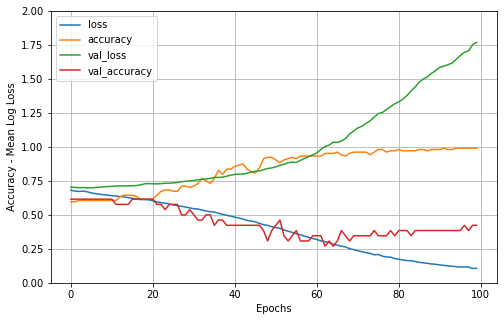

In [27]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

# categorical_accuracy es el training accuracy
# val_categorical_accuracy es el validation accuracy
# loss es el training loss
# val_loss es el validation loss

# Overfitting:
# Por un lado la Accuracy de los datos de entrenamiento aumenta con las epochs,
# mientras que la Accuracy de los datos de validación disminuye o se mantiene constante a lo largo de las epochs. 
# La Loss de los datos de validación alcanza su mínimo después de pocos epochs y luego empieza a subir, 
# mientras que la Loss de los datos de entrenamiento disminuye linealmente.

In [28]:
history.params

{'verbose': 2, 'epochs': 100, 'steps': 4}

In [29]:
results[-1:]

,loss,accuracy,val_loss,val_accuracy
99,0.106621,0.990385,1.769947,0.423077


In [30]:
print ("Accuracy for the training set: ", results.values[-1:][0][1])

Accuracy for the training set:  0.9903846383094788


In [31]:
print ("Accuracy for the development test set: ", results.values[-1:][0][3])

Accuracy for the development test set:  0.42307692766189575


#### Let's see how the model predicts using the development test set:

In [32]:
dev_predictions=model.predict(X_dev).round(2) 
dev_predictions[:20]

array([[0.46, 0.54],
       [0.4 , 0.6 ],
       [0.08, 0.92],
       [0.95, 0.05],
       [0.96, 0.04],
       [0.99, 0.01],
       [0.98, 0.02],
       [0.91, 0.09],
       [0.88, 0.12],
       [0.98, 0.02],
       [0.89, 0.11],
       [0.51, 0.49],
       [0.72, 0.28],
       [0.76, 0.24],
       [0.12, 0.88],
       [0.01, 0.99],
       [0.16, 0.84],
       [0.02, 0.98],
       [0.04, 0.96],
       [0.05, 0.95]], dtype=float32)

In [33]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [34]:
y_dev[:20]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [35]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(y_dev,1))
print (dev_correct_predictions[:30])

[False False False False False False False False False False False  True
  True  True False False  True  True  True  True  True  True  True  True
 False False]


In [36]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({False: 15, True: 11})

### 9. Save model

We save the model if it is better than others 

In [37]:
# Save
model.save('./Modelos/CNN_model1_ce_PARES_DIA1.h5') # Change the name in each model

In [38]:
# Extract
"""
new_model = keras.models.load_model('./Modelos/EGG_prac1_ANN_model3.h5')

import numpy as np

# Verify state
new_predictions = new_model.predict(X_dev)
np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

# Note that the optimizer state is also preserved:
# you can resume training where you left off.
"""

"\nnew_model = keras.models.load_model('./Modelos/EGG_prac1_ANN_model3.h5')\n\nimport numpy as np\n\n# Verify state\nnew_predictions = new_model.predict(X_dev)\nnp.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)\n\n# Note that the optimizer state is also preserved:\n# you can resume training where you left off.\n"

### 10 - Final Test

#### 10.1 - Load the final test set

#### 10.2 - Evaluate the model

In [39]:
"""
from collections import Counter
def predictWithModel(model, X_test, y_test, task1, task2, task3=""):
    model.evaluate(X_test, y_test)
    test_predictions = model.predict(X_test)
    test_rounded_predictions=np.round(test_predictions)
    indices = np.argmax(test_predictions,1)
    for row, index in zip(test_rounded_predictions, indices): row[index]=1
    print(test_rounded_predictions[:20])
    
    # ACCURACY:
    test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(y_test,1))
    print()
    print(test_correct_predictions)
    print(type(test_correct_predictions))
    final_test_prediction_results=Counter(test_correct_predictions)
    
    success = np.mean(test_rounded_predictions == y_test)*100
    
    return final_test_prediction_results, success

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-39-01c14ef9ee9b>, line 20)

In [ ]:
"""
users = ["0091"]
for u in users:   
    print("USER:", u)
    #X_test, y_test = readRegisterAndReturnXy(u, total_records, 122, 123, 127)
    accuracy, success = predictWithModel(model, X_test, y_test, 402,404)
    print(u, accuracy, success)
    print()